In [2]:
import glob
from natsort import natsorted # for alphabetical sorting
# import sys
# import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import xesmf as xe

In [3]:
data_dir='/work/hpc/users/kerrie/UN_FAO/data/agERA5/'
maskfile='/work/hpc/users/kerrie/UN_FAO/data/orig/DataDownload03152023/ALOSmask5m_fill.rst'
demfile='/work/hpc/users/kerrie/UN_FAO/data/orig/DataDownload03152023/ALOSdem5m_fill.rst'

grid01file='/work/hpc/users/kerrie/UN_FAO/data/agERA5/orig/Precipitation-Flux_C3S-glob-agric_AgERA5_19800101_final-v1.0.nc'

outvars=['prcp','srad','tmax','tmin','vapr','wspd']
cdsfvars=['Precipitation-Flux','Solar-Radiation-Flux','Temperature-Air-2m-Max-Day-Time','Temperature-Air-2m-Min-Night-Time','Vapour-Pressure-Mean','Wind-Speed-10m-Mean']
cds_filesuf='_C3S-glob-agric_AgERA5_1980????_final-v1.0.nc'
cdsvarnames=[s.replace('-','_') for s in cdsfvars]

year=1980

timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lat_encoding={'_FillValue':None}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}
lon_encoding={'_FillValue':None}
var_encoding = {'zlib':True,'dtype':'float32'}


In [1]:
# check we have all 365 days for each variable
for var in cdsfvars:
    filelist=glob.glob(data_dir+'orig/'+var+cds_filesuf)
    print(len(filelist))

NameError: name 'cdsfvars' is not defined

# Functions

In [4]:
# don't need to use this one unless you want to see the list of files
def get_filelist(outvarname):
    try:
        i=outvars.index(outvarname)
    except:
        print('no variable named',outvarname)
        return
    files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[i]+cds_filesuf))
    return files

In [5]:
# we're loading all this data into memory so this one may take a minute or two
def get_daily_dataset(outvarname):
    try:
        i=outvars.index(outvarname)
    except:
        print('no variable named',outvarname)
        return
    
    files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[i]+cds_filesuf))        
    ds=xr.open_mfdataset(files).load()
    ds=ds.rename({cdsvarnames[i]:outvars[i]})
    del ds.attrs['history']
    return ds    

In [6]:
def compute_monthly_mean(ds_daily,metadata):
    var=list(ds.keys())[0]
    m_ds=ds_daily.resample(time='MS').sum('time',skipna=False)
    m_ds[var].attrs=metadata
    return m_ds

In [7]:
def compute_dev_sum(ds_daily,metadata):
    var=list(ds_daily.keys())[0]
    dd_ds=ds_daily.groupby('time.month')/ds_daily.groupby('time.month').sum('time')
    dd_ds=dd_ds.drop('month')
    
    # create a 3D landmask
    landmask=xr.where(np.isfinite(ds_daily.isel(time=0)),1,0).drop('time')
    landmask=landmask.rename({var:'landmask'})
    landmask=landmask.landmask
    landmask=landmask.expand_dims({'time':dd_ds.time.data})
    dd_var=xr.where((landmask==1) & ~np.isfinite(dd_ds[var]),0,dd_ds[var])

    # this is annoying but xr.where erases metadata
    # copy all the metdata
    attrstime=dd_ds.time.attrs
    attrslat=dd_ds.lat.attrs
    attrslon=dd_ds.lon.attrs
    attrsvar=dd_ds[var].attrs

    # replace the variable and metadata in the dataset
    dd_ds[var]=dd_var
    dd_ds['time'].attrs=attrstime
    dd_ds['lat'].attrs=attrslat
    dd_ds['lon'].attrs=attrslon
    dd_ds[var].attrs=metadata
    
    return dd_ds

In [8]:
def plot_day_mon_dev(t,ds_daily,ds_monthly,ds_dev):
    var=list(ds_daily.keys())[0]

    fig=plt.figure(figsize=(23,5))
    ax=fig.add_subplot(131)
    ds[var].sel(time=t).plot(ax=ax)
    plt.title('daily '+var+' '+t,fontsize='xx-large')

    ax=fig.add_subplot(132)
    m_ds[var].sel(time=t).plot(ax=ax)
    plt.title('monthly mean '+var+' '+t[0:7],fontsize='xx-large')

    ax=fig.add_subplot(133)
    dd_ds[var].sel(time=t).plot(ax=ax)
    plt.title('daily dev '+var+' '+t,fontsize='xx-large')

    plt.show()

In [9]:
def write_daily(ds_daily):    
    var=list(ds_daily.keys())[0]
    ds_daily.to_netcdf(data_dir+'daily/'+var+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      var:var_encoding})
    return 'finished writing '+data_dir+'daily/'+var+'_AgERA5_daily_'+str(year)+'.nc'

In [10]:
def write_monthly(ds_monthly):
    var=list(ds_monthly.keys())[0]
    ds_monthly.to_netcdf(data_dir+'monthly/'+var+'_AgERA5_monthly_'+str(year)+'.nc',
                encoding={'lat':lat_encoding,
                          'lon':lon_encoding,
                          'time':time_encoding,
                          var:var_encoding})
    return 'finished writing '+data_dir+'monthly/'+var+'_AgERA5_monthly_'+str(year)+'.nc'

In [11]:
def write_dev(ds_dev):
    var=list(ds_dev.keys())[0]
    ds_dev.to_netcdf(data_dir+'dailydev/'+var+'_AgERA5_dailydev_'+str(year)+'.nc',
                encoding={'lat':lat_encoding,
                          'lon':lon_encoding,
                          'time':time_encoding,
                          var:var_encoding})    
    return 'finished writing '+data_dir+'dailydev/'+var+'_AgERA5_dailydev_'+str(year)+'.nc'

# regrid

In [12]:
def open_rst_2D(f):
    var=xr.open_dataset(f,engine='rasterio').squeeze()['band_data'] 
    var=var.drop('band')
    return var

In [15]:
mask_5m=open_rst_2D(maskfile)
mask_5m

<xarray.DataArray 'band_data' (y: 2160, x: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int64 ...
Attributes:
    units:    unspecified

In [24]:
orog_5m=open_rst_2D(demfile)
orog_5m=orog_5m.rename({'y':'lat','x':'lon'})
orog_5m

<xarray.DataArray 'band_data' (lat: 2160, lon: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int64 ...
Attributes:
    units:    m

In [ ]:
# THIS IS WHERE YOU LEFT OFF

# NEXT STEPS

# - get global geopotential from ECMWF HRES at 0.1 degree grid
# - regrid that to the 5m grid (assuming bilinear)
# - compute the difference between that and the ALOSdem file (orog_5m)
# - apply the temperature correction (assuming 6.5C/km)

In [21]:
# grid01=xr.open_dataset(grid01file).squeeze().load()
# del grid01.attrs['history']
# grid01

<xarray.Dataset>
Dimensions:             (lon: 3600, lat: 1801)
Coordinates:
    time                datetime64[ns] 1980-01-01
  * lon                 (lon) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * lat                 (lat) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
Data variables:
    Precipitation_Flux  (lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [25]:
# regridder=xe.Regridder(orog_5m,grid01,'bilinear')

/work/hpc/users/kerrie/USDA_VSV_CMIP5/xr-xe-dask/lib/python3.9/site-packages/xarray/core/dataarray.py:854: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [26]:
# orog_01=regridder(orog_5m,keep_attrs=True)
# orog_01

<xarray.DataArray 'band_data' (lat: 1801, lon: 3600)>
array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  nan,  nan, ...,  nan,  nan,  nan],
       [ 0. ,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ 0. , 61. , 61. , ..., 55. , 56.4, 60. ],
       [ 0. , 61. , 61. , ..., 55. , 56.4, 60. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]], dtype=float32)
Coordinates:
    spatial_ref  int64 ...
    time         datetime64[ns] 1980-01-01
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat          (lat) float64 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
Attributes:
    units:          m
    regrid_method:  bilinear

# test the process with precip

In [4]:
iv=0
files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[iv]+cds_filesuf))
files[0:4]

['/work/hpc/users/kerrie/UN_FAO/data/agERA5/orig/Precipitation-Flux_C3S-glob-agric_AgERA5_19800101_final-v1.0.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/agERA5/orig/Precipitation-Flux_C3S-glob-agric_AgERA5_19800102_final-v1.0.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/agERA5/orig/Precipitation-Flux_C3S-glob-agric_AgERA5_19800103_final-v1.0.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/agERA5/orig/Precipitation-Flux_C3S-glob-agric_AgERA5_19800104_final-v1.0.nc']

In [5]:
# load all daily data
# it's chunked on file so it loads as a dask array meaning this data is not loaded into memory
ds=xr.open_mfdataset(files).load()
ds=ds.rename({cdsvarnames[iv]:outvars[iv]})
del ds.attrs['history']
ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    prcp     (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [7]:
# compute the monthly sum (precip) or mean
# .compute() because we want to load this into memory
m_ds=ds.resample(time='MS').sum('time',skipna=False)#.compute()

var_attrs={'standard_name':'total_precipitation','long_name':'total precipitation','units':'mm month-1','description':"monthly aggregate precipitation"}
m_ds[outvars[iv]].attrs=var_attrs
m_ds

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1801, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    prcp     (time, lat, lon) float32 nan nan nan nan ... 3.39 3.39 3.39 3.39
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

### it's unclear here what to do about divide 0 (desert areas where there is zero precip in a month)

### should the daily fraction be 0 or 1

### i'm choosing 0

In [8]:
# compute the daily deviation
# in the case of precip this is the daily fraction of the month's precip
# .compute() because we want to load this into memory

# let the compute divide by zero and replace the result with nan

dd_ds=ds.groupby('time.month')/ds.groupby('time.month').sum('time')
# dd_ds=dd_ds.compute()

# make pretty
var_attrs={'standard_name':'precipitation_fraction','long_name':'precipitation fraction','units':'unitless','description':"daily fraction of each month's aggregate precipitation"}
dd_ds=dd_ds.drop('month')
dd_ds[outvars[iv]].attrs=var_attrs

dd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    prcp     (time, lat, lon) float32 nan nan nan ... 0.06785 0.06785 0.06785

### deal with replacing the divide 0 nan values so there aren't data holes

In [9]:
# create a 3D landmask
landmask=xr.where(np.isfinite(m_ds.isel(time=0)),1,0).drop('time')
landmask=landmask.rename({outvars[iv]:'landmask'})
landmask=landmask.landmask
landmask=landmask.expand_dims({'time':dd_ds.time.data})
# landmask[0,:,:].plot()

In [10]:
# find the holes and replace with 0
dd_var=xr.where((landmask==1) & ~np.isfinite(dd_ds[outvars[iv]]),0,dd_ds[outvars[iv]])

In [11]:
# this is annoying but xr.where erases metadata
# copy all the metdata
attrstime=dd_ds.time.attrs
attrslat=dd_ds.lat.attrs
attrslon=dd_ds.lon.attrs
attrsvar=dd_ds[outvars[iv]].attrs


In [12]:
# replace the variable and metadata in the dataset
dd_ds[outvars[iv]]=dd_var
dd_ds['time'].attrs=attrstime
dd_ds['lat'].attrs=attrslat
dd_ds['lon'].attrs=attrslon
dd_ds[outvars[iv]].attrs=attrsvar

# check that nothing looks whacky

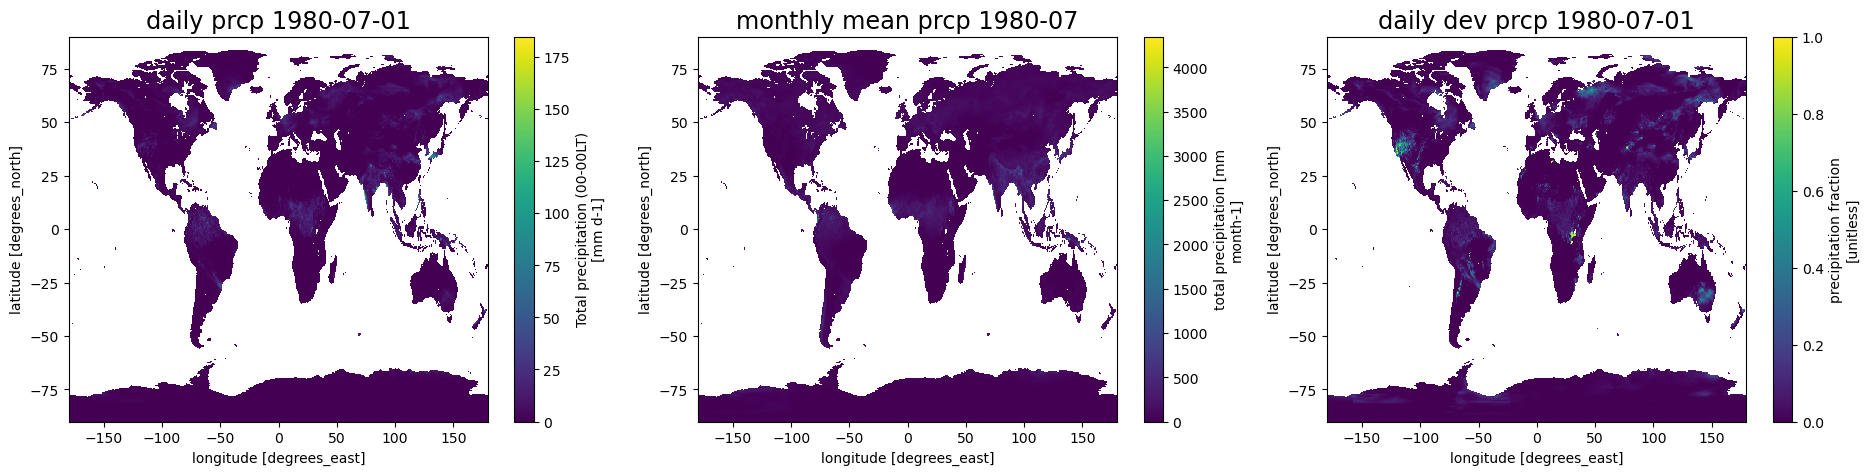

In [19]:
ptime='1980-07-01'

fig=plt.figure(figsize=(23,5))
ax=fig.add_subplot(131)
ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily '+outvars[iv]+' '+ptime,fontsize='xx-large')

ax=fig.add_subplot(132)
m_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('monthly mean '+outvars[iv]+' '+ptime[0:7],fontsize='xx-large')

ax=fig.add_subplot(133)
dd_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily dev '+outvars[iv]+' '+ptime,fontsize='xx-large')

plt.show()

# write netcdf files

In [64]:
var_encoding = {'zlib':True,'dtype':'float32'}

In [17]:
# write out single files per variable for daily, monthly, and daily deviation


# writing with compression will take a few minutes
ds.load().to_netcdf(data_dir+'daily/'+outvars[iv]+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [18]:
# writing with compression will take a few minutes
m_ds.to_netcdf(data_dir+'monthly/'+outvars[iv]+'_AgERA5_monthly_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [65]:
# writing with compression will take a few minutes
dd_ds.to_netcdf(data_dir+'dailydev/'+outvars[iv]+'_AgERA5_dailydev_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

# i'm too lazy to write a function for all this

# Srad

how are they calculating the dev of srad? same as precip (sum) or same as temperature (mean)

I'm choosing mean here bcs the srad daily dev data gunter gave me have negative values

In [20]:
iv=1
files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[iv]+cds_filesuf))
files[0]

'/work/hpc/users/kerrie/UN_FAO/data/agERA5/orig/Solar-Radiation-Flux_C3S-glob-agric_AgERA5_19800101_final-v1.0.nc'

In [21]:
# load all daily data
# it's chunked on file so it loads as a dask array meaning this data is not loaded into memory
ds=xr.open_mfdataset(files).load()
ds=ds.rename({cdsvarnames[iv]:outvars[iv]})
del ds.attrs['history']
ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    srad     (time, lat, lon) float32 nan nan nan ... 3.505e+07 3.505e+07
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [22]:
# compute the monthly sum (precip) or mean
# .compute() because we want to load this into memory

# # for sum
# m_ds=ds.resample(time='MS').sum('time',skipna=False).compute()
# var_attrs={'standard_name':'total_surface_solar_radiation_downwards',
#            'long_name':'total surface solar radiation downwards',
#            'units':'J m-2 month-1',
#            'description':"monthly aggregate surface downward srad"}

# for mean
m_ds=ds.resample(time='MS').mean('time',skipna=False)#.compute()
var_attrs={'standard_name':'mean_surface_solar_radiation_downwards',
           'long_name':'mean surface solar radiation downwards',
           'units':'J m-2 d-1',
           'description':"monthly mean surface downward srad"}

m_ds[outvars[iv]].attrs=var_attrs
m_ds

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1801, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    srad     (time, lat, lon) float32 nan nan nan ... 3.811e+07 3.811e+07
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [23]:
# compute the daily deviation
# in the case of precip this is the daily fraction of the month's precip
# .compute() because we want to load this into memory

# # for sum
# dd_ds=ds.groupby('time.month')/ds.groupby('time.month').sum('time')
# var_attrs={'standard_name':'surface_solar_radiation_downwards_fraction',
#            'long_name':'surface solar radiation downwards fraction',
#            'units':'unitless',
#            'description':"daily fraction of each month's aggregate surface solar radiation downwards"}

# for mean
dd_ds=ds.groupby('time.month')-ds.groupby('time.month').mean('time',skipna=False)
var_attrs={'standard_name':'surface_solar_radiation_downwards_deviation',
           'long_name':'surface solar radiation downwards deviation',
           'units':'J m-2 d-1',
           'description':"daily deviation of monthly mean surface solar radiation downwards"}

# dd_ds=dd_ds.compute()

# make pretty
dd_ds=dd_ds.drop('month')
dd_ds[outvars[iv]].attrs=var_attrs

dd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    srad     (time, lat, lon) float32 nan nan nan ... -3.069e+06 -3.069e+06

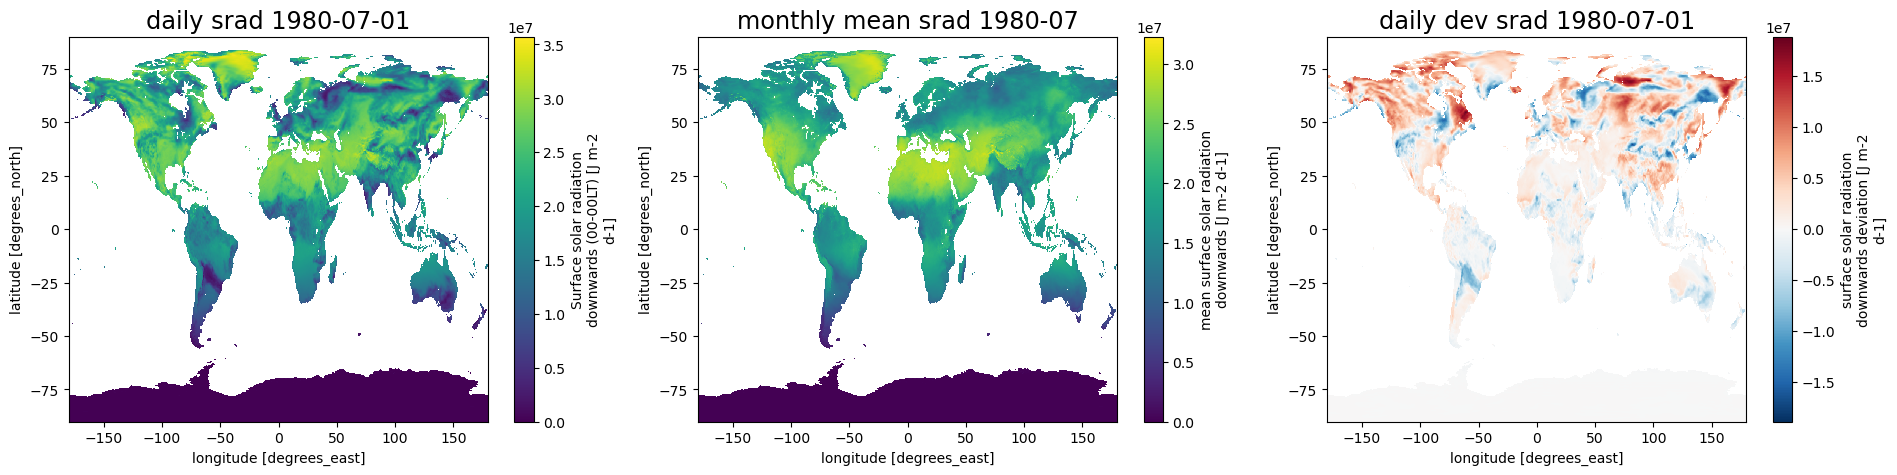

In [24]:
ptime='1980-07-01'

fig=plt.figure(figsize=(23,5))
ax=fig.add_subplot(131)
ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily '+outvars[iv]+' '+ptime,fontsize='xx-large')

ax=fig.add_subplot(132)
m_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('monthly mean '+outvars[iv]+' '+ptime[0:7],fontsize='xx-large')

ax=fig.add_subplot(133)
dd_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily dev '+outvars[iv]+' '+ptime,fontsize='xx-large')

plt.show()

In [35]:
# write out single files per variable for daily, monthly, and daily deviation

var_encoding = {'zlib':True,'dtype':'float32'}

# writing with compression will take a few minutes
ds.load().to_netcdf(data_dir+'daily/'+outvars[iv]+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [36]:
# writing with compression will take a few minutes
m_ds.to_netcdf(data_dir+'monthly/'+outvars[iv]+'_AgERA5_monthly_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [37]:
# writing with compression will take a few minutes
dd_ds.to_netcdf(data_dir+'dailydev/'+outvars[iv]+'_AgERA5_dailydev_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

# Tmax

In [25]:
iv=2
files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[iv]+cds_filesuf))
ds=xr.open_mfdataset(files).load()
ds=ds.rename({cdsvarnames[iv]:outvars[iv]})
del ds.attrs['history']
ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    tmax     (time, lat, lon) float32 nan nan nan nan ... 246.6 246.6 246.6
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [26]:
# compute the monthly sum (precip) or mean
# .compute() because we want to load this into memory

# for mean
m_ds=ds.resample(time='MS').mean('time',skipna=False)#.compute()
var_attrs={'standard_name':'mean_day_time_maximum_2m_temperature',
           'long_name':'mean day time maximum 2m temperature',
           'units':'K',
           'description':"monthly mean day time maximum surface air temperature at 2m"}

m_ds[outvars[iv]].attrs=var_attrs
m_ds

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1801, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    tmax     (time, lat, lon) float32 nan nan nan nan ... 243.7 243.7 243.7
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [27]:
# compute the daily deviation
# in the case of temperature this is the daily deviation from each monthly mean
# .compute() because we want to load this into memory

dd_ds=ds.groupby('time.month')-ds.groupby('time.month').mean('time',skipna=False)
var_attrs={'standard_name':'day_time_maximum_2m_temperature_deviation',
           'long_name':'day time maximum 2m temperature deviation',
           'units':'K',
           'description':"daily deviation of monthly mean day time maximum surface air temperature at 2m"}

# dd_ds=dd_ds.compute()

# make pretty
dd_ds=dd_ds.drop('month')
dd_ds[outvars[iv]].attrs=var_attrs

dd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    tmax     (time, lat, lon) float32 nan nan nan nan ... 2.961 2.961 2.961

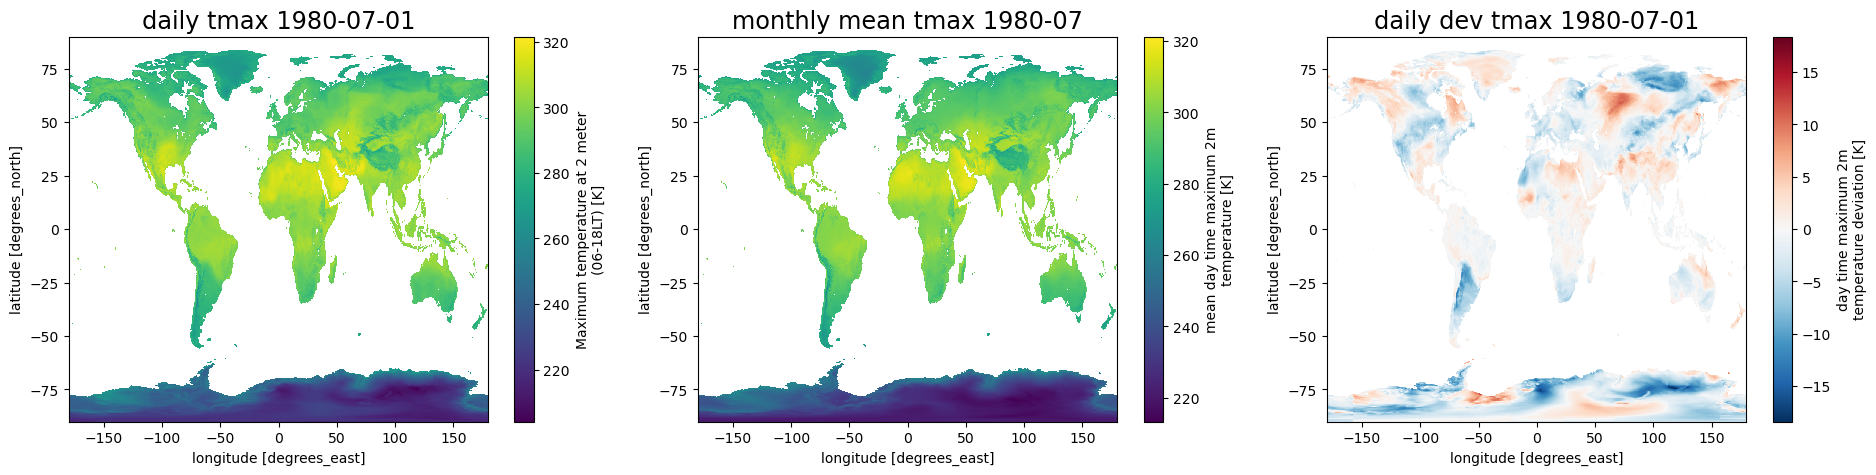

In [28]:
ptime='1980-07-01'

fig=plt.figure(figsize=(23,5))
ax=fig.add_subplot(131)
ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily '+outvars[iv]+' '+ptime,fontsize='xx-large')

ax=fig.add_subplot(132)
m_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('monthly mean '+outvars[iv]+' '+ptime[0:7],fontsize='xx-large')

ax=fig.add_subplot(133)
dd_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily dev '+outvars[iv]+' '+ptime,fontsize='xx-large')

plt.show()

In [50]:
var_encoding = {'zlib':True,'dtype':'float32'}

In [51]:
# write out single files per variable for daily, monthly, and daily deviation


# writing with compression will take a few minutes
ds.load().to_netcdf(data_dir+'daily/'+outvars[iv]+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [55]:
# writing with compression will take a few minutes
m_ds.to_netcdf(data_dir+'monthly/'+outvars[iv]+'_AgERA5_monthly_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [53]:
# writing with compression will take a few minutes
dd_ds.to_netcdf(data_dir+'dailydev/'+outvars[iv]+'_AgERA5_dailydev_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

# Tmin

In [29]:
iv=3
files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[iv]+cds_filesuf))
ds=xr.open_mfdataset(files).load()
ds=ds.rename({cdsvarnames[iv]:outvars[iv]})
del ds.attrs['history']
ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    tmin     (time, lat, lon) float32 nan nan nan nan ... 243.0 243.0 243.0
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [30]:
# compute the monthly sum (precip) or mean
# .compute() because we want to load this into memory

# for mean
m_ds=ds.resample(time='MS').mean('time',skipna=False)#.compute()
var_attrs={'standard_name':'mean_day_time_minimum_2m_temperature',
           'long_name':'mean day time minimum 2m temperature',
           'units':'K',
           'description':"monthly mean day time minimum surface air temperature at 2m"}

m_ds[outvars[iv]].attrs=var_attrs
m_ds

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1801, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    tmin     (time, lat, lon) float32 nan nan nan nan ... 242.7 242.7 242.7
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [31]:
# compute the daily deviation
# in the case of temperature this is the daily deviation from each monthly mean
# .compute() because we want to load this into memory

dd_ds=ds.groupby('time.month')-ds.groupby('time.month').mean('time',skipna=False)
var_attrs={'standard_name':'day_time_minimum_2m_temperature_deviation',
           'long_name':'day time minimum 2m temperature deviation',
           'units':'K',
           'description':"daily deviation of monthly mean day time minimum surface air temperature at 2m"}

# dd_ds=dd_ds.compute()

# make pretty
dd_ds=dd_ds.drop('month')
dd_ds[outvars[iv]].attrs=var_attrs

dd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    tmin     (time, lat, lon) float32 nan nan nan nan ... 0.2571 0.2571 0.2571

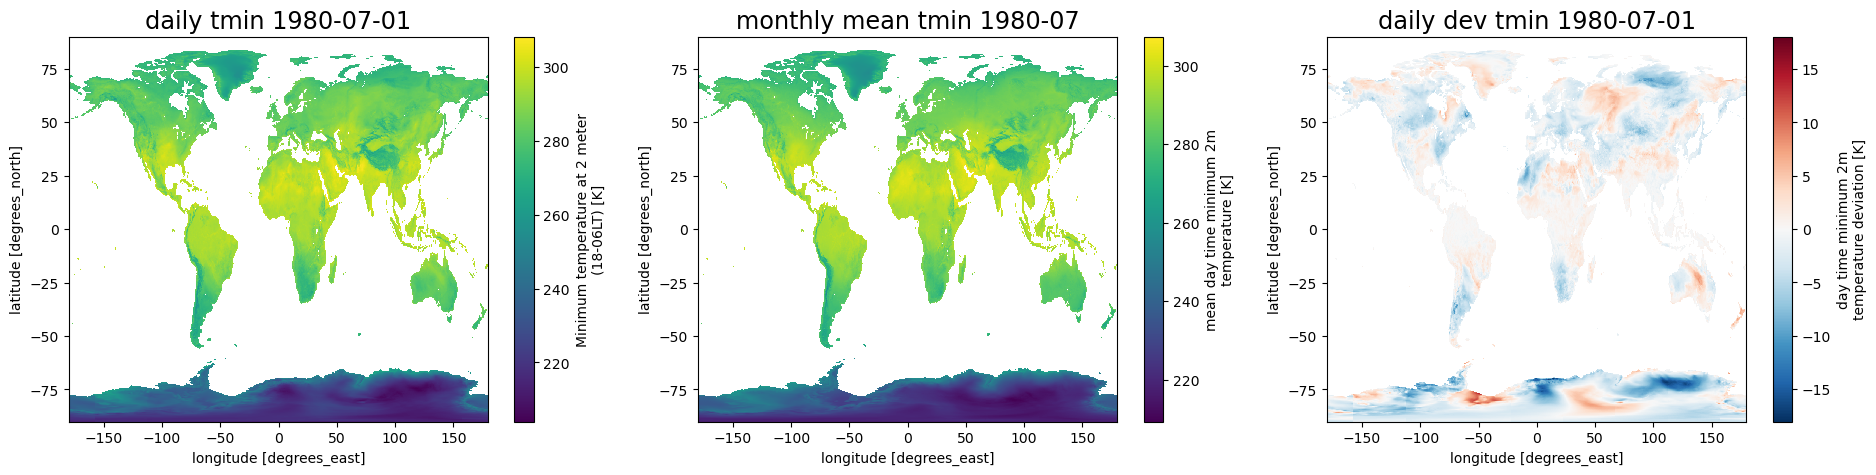

In [32]:
ptime='1980-07-01'

fig=plt.figure(figsize=(23,5))
ax=fig.add_subplot(131)
ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily '+outvars[iv]+' '+ptime,fontsize='xx-large')

ax=fig.add_subplot(132)
m_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('monthly mean '+outvars[iv]+' '+ptime[0:7],fontsize='xx-large')

ax=fig.add_subplot(133)
dd_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily dev '+outvars[iv]+' '+ptime,fontsize='xx-large')

plt.show()

In [33]:
var_encoding = {'zlib':True,'dtype':'float32'}

In [34]:
# write out single files per variable for daily, monthly, and daily deviation
# writing with compression will take a few minutes
ds.to_netcdf(data_dir+'daily/'+outvars[iv]+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [35]:
# writing with compression will take a few minutes
m_ds.to_netcdf(data_dir+'monthly/'+outvars[iv]+'_AgERA5_monthly_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [36]:
# writing with compression will take a few minutes
dd_ds.to_netcdf(data_dir+'dailydev/'+outvars[iv]+'_AgERA5_dailydev_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

# Vapr

In [37]:
iv=4
files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[iv]+cds_filesuf))
ds=xr.open_mfdataset(files).load()
ds=ds.rename({cdsvarnames[iv]:outvars[iv]})
del ds.attrs['history']
ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    vapr     (time, lat, lon) float32 nan nan nan nan ... 0.4254 0.4254 0.4254
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [38]:
# compute the monthly sum (precip) or mean
# .compute() because we want to load this into memory

# for mean
m_ds=ds.resample(time='MS').mean('time',skipna=False)#.compute()
var_attrs={'standard_name':'mean_vapour_pressure',
           'long_name':'mean vapour pressure',
           'units':'hPa',
           'description':"monthly mean vapour pressure"}

m_ds[outvars[iv]].attrs=var_attrs
m_ds

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1801, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    vapr     (time, lat, lon) float32 nan nan nan nan ... 0.3331 0.3331 0.3331
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [39]:
# compute the daily deviation
# in the case of temperature this is the daily deviation from each monthly mean
# .compute() because we want to load this into memory

dd_ds=ds.groupby('time.month')-ds.groupby('time.month').mean('time',skipna=False)
var_attrs={'standard_name':'vapour_pressure_deviation',
           'long_name':'vapour pressure deviation',
           'units':'hPa',
           'description':"daily deviation of monthly mean vapour pressure"}

# dd_ds=dd_ds.compute()

# make pretty
dd_ds=dd_ds.drop('month')
dd_ds[outvars[iv]].attrs=var_attrs

dd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    vapr     (time, lat, lon) float32 nan nan nan ... 0.09227 0.09227 0.09227

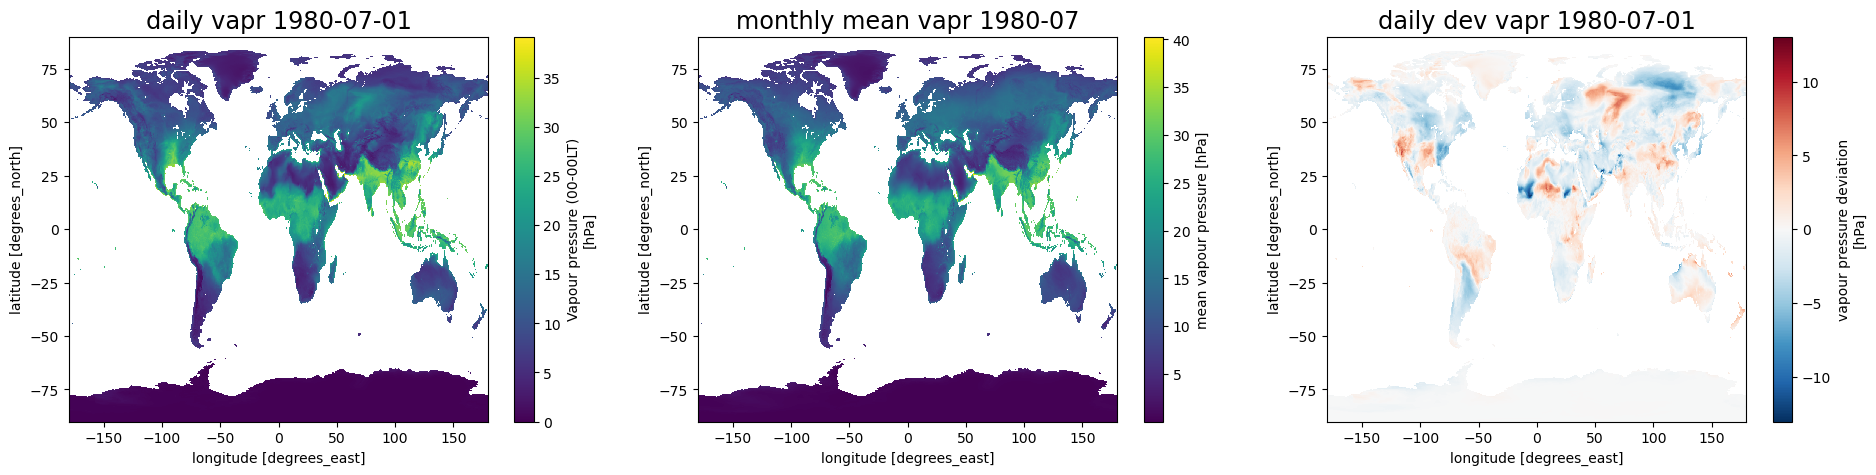

In [40]:
ptime='1980-07-01'

fig=plt.figure(figsize=(23,5))
ax=fig.add_subplot(131)
ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily '+outvars[iv]+' '+ptime,fontsize='xx-large')

ax=fig.add_subplot(132)
m_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('monthly mean '+outvars[iv]+' '+ptime[0:7],fontsize='xx-large')

ax=fig.add_subplot(133)
dd_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily dev '+outvars[iv]+' '+ptime,fontsize='xx-large')

plt.show()

In [41]:
var_encoding = {'zlib':True,'dtype':'float32'}

In [42]:
# write out single files per variable for daily, monthly, and daily deviation
# writing with compression will take a few minutes
ds.to_netcdf(data_dir+'daily/'+outvars[iv]+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [43]:
# writing with compression will take a few minutes
m_ds.to_netcdf(data_dir+'monthly/'+outvars[iv]+'_AgERA5_monthly_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [44]:
# writing with compression will take a few minutes
dd_ds.to_netcdf(data_dir+'dailydev/'+outvars[iv]+'_AgERA5_dailydev_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

# Wspd

In [45]:
iv=5
files=natsorted(glob.glob(data_dir+'orig/'+cdsfvars[iv]+cds_filesuf))
ds=xr.open_mfdataset(files).load()
ds=ds.rename({cdsvarnames[iv]:outvars[iv]})
del ds.attrs['history']
ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    wspd     (time, lat, lon) float32 nan nan nan nan ... 1.694 1.694 1.694
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [53]:
# compute the monthly sum (precip) or mean
# .compute() because we want to load this into memory

# for mean
m_ds=ds.resample(time='MS').mean('time',skipna=False)#.compute()
var_attrs={'standard_name':'mean_10m_wind_speed',
           'long_name':'mean 10m wind speed',
           'units':'m s-1',
           'description':"monthly mean 10m wind speed"}

m_ds[outvars[iv]].attrs=var_attrs
m_ds

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1801, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    wspd     (time, lat, lon) float32 nan nan nan nan ... 3.948 3.948 3.948
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [54]:
# compute the daily deviation
# in the case of temperature this is the daily deviation from each monthly mean
# .compute() because we want to load this into memory

dd_ds=ds.groupby('time.month')-ds.groupby('time.month').mean('time',skipna=False)
var_attrs={'standard_name':'10m_wind_speed_deviation',
           'long_name':'10m wind speed deviation',
           'units':'m s-1',
           'description':"daily deviation of monthly 10m wind speed"}

# dd_ds=dd_ds.compute()

# make pretty
dd_ds=dd_ds.drop('month')
dd_ds[outvars[iv]].attrs=var_attrs

dd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 3600, lat: 1801)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    wspd     (time, lat, lon) float32 nan nan nan nan ... -2.254 -2.254 -2.254

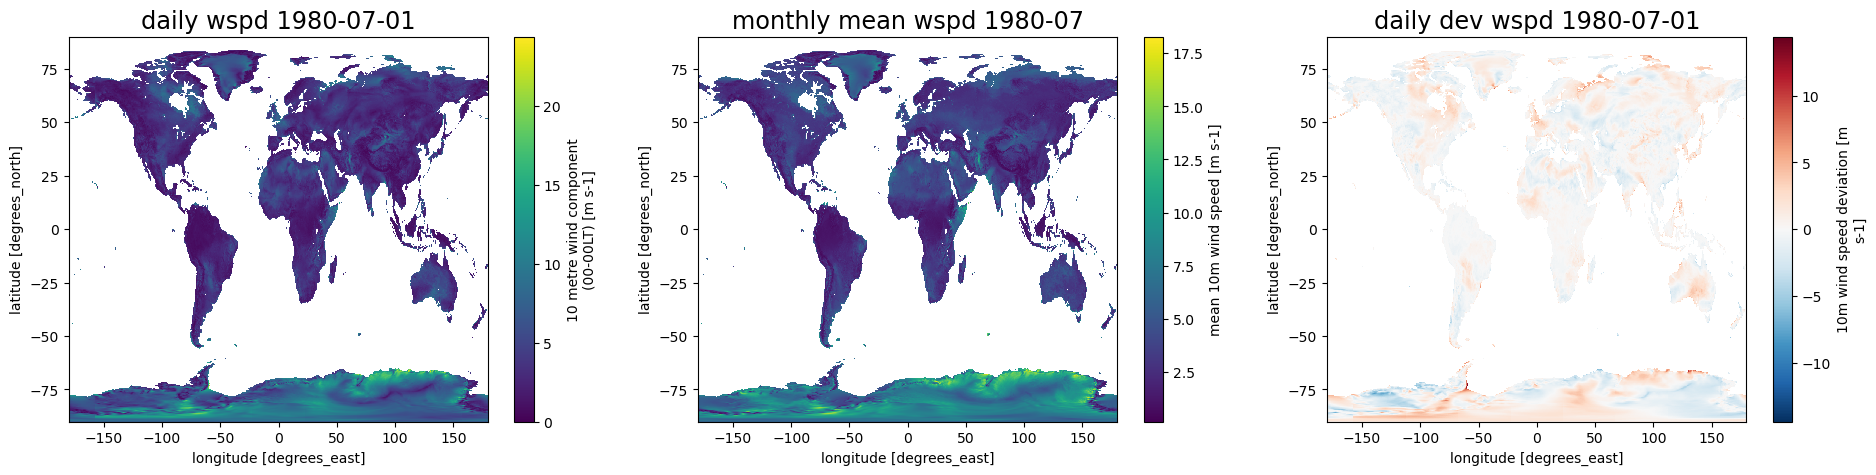

In [55]:
ptime='1980-07-01'

fig=plt.figure(figsize=(23,5))
ax=fig.add_subplot(131)
ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily '+outvars[iv]+' '+ptime,fontsize='xx-large')

ax=fig.add_subplot(132)
m_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('monthly mean '+outvars[iv]+' '+ptime[0:7],fontsize='xx-large')

ax=fig.add_subplot(133)
dd_ds[outvars[iv]].sel(time=ptime).plot(ax=ax)
plt.title('daily dev '+outvars[iv]+' '+ptime,fontsize='xx-large')

plt.show()

In [56]:
var_encoding = {'zlib':True,'dtype':'float32'}

In [57]:
# write out single files per variable for daily, monthly, and daily deviation
# writing with compression will take a few minutes
ds.to_netcdf(data_dir+'daily/'+outvars[iv]+'_AgERA5_daily_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [58]:
# writing with compression will take a few minutes
m_ds.to_netcdf(data_dir+'monthly/'+outvars[iv]+'_AgERA5_monthly_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})

In [59]:
# writing with compression will take a few minutes
dd_ds.to_netcdf(data_dir+'dailydev/'+outvars[iv]+'_AgERA5_dailydev_'+str(year)+'.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      outvars[iv]:var_encoding})